In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
plt.style.use('ggplot')
from geopy.geocoders import Nominatim

# Create a BigQuery client
client = bigquery.Client.from_service_account_json("key.json")

In [2]:
query = """
SELECT * FROM `cse-6242-fa24-lz.hurricane.points`
"""
points = client.query(query).to_dataframe()

/home/chen112p/.pyenv/versions/3.12.4/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [3]:
query = """
SELECT * FROM `cse-6242-fa24-lz.hurricane.radii`
"""
radii = client.query(query).to_dataframe()


# radii: wind speed in knot  avg wind speed in the 
# synoptime: advisory time 
# stormnum: storm count of the year
# ne: distance of wind speed in Nautical Miles in in NE quadrant

In [4]:
points_cat3plus = points[points["ss"] >= 3]

point_time_cat3plus = points_cat3plus[['stormid','dtg']]
point_time_cat3plus['dtg'] = pd.to_datetime(point_time_cat3plus['dtg'].astype(int).astype(str), format='%Y%m%d%H')

storm_synoptime_cat3plus = point_time_cat3plus.groupby('stormid').agg(
            earliest_synoptime=('dtg', 'min'),
            latest_synoptime=('dtg', 'max')).sort_values('earliest_synoptime')
storm_synoptime_cat3plus['earliest_synoptime'] = storm_synoptime_cat3plus['earliest_synoptime'].dt.round('D')
storm_synoptime_cat3plus['latest_synoptime'] = storm_synoptime_cat3plus['latest_synoptime'].dt.round('D')

/tmp/ipykernel_407743/822559188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_time_cat3plus['dtg'] = pd.to_datetime(point_time_cat3plus['dtg'].astype(int).astype(str), format='%Y%m%d%H')


In [5]:
point_time = points[['stormid','dtg']]
point_time['dtg'] = pd.to_datetime(point_time['dtg'].astype(int).astype(str), format='%Y%m%d%H')

storm_synoptime = point_time.groupby('stormid').agg(
            earliest_synoptime=('dtg', 'min'),
            latest_synoptime=('dtg', 'max')).sort_values('earliest_synoptime')
storm_synoptime['earliest_synoptime'] = storm_synoptime['earliest_synoptime'].dt.round('D')
storm_synoptime['latest_synoptime'] = storm_synoptime['latest_synoptime'].dt.round('D')

/tmp/ipykernel_407743/3939783047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_time['dtg'] = pd.to_datetime(point_time['dtg'].astype(int).astype(str), format='%Y%m%d%H')


In [6]:
months = pd.date_range('2014-06-01', '2023-11-01', freq='MS')
months = months[(months.month >= 6) & (months.month <= 11)]
monthly_counts_unique = []
monthly_counts_cat3_unique = []
for month in months:
    month_start = month
    month_end = month + pd.offsets.MonthEnd(1)
    
    unique_days = set()
    unique_days_cat3 = set()
    # Go through each storm's period and add each day to the set if it falls within the month
    for _, row in storm_synoptime.iterrows():
        overlap_start = max(row['earliest_synoptime'], month_start)
        overlap_end = min(row['latest_synoptime'], month_end)
        
        # If there is an overlap within the current month, add each day to the unique_days set
        if overlap_start < overlap_end:
            for single_day in pd.date_range(overlap_start, overlap_end, freq='D'):
                unique_days.add(single_day)
    for _, row in storm_synoptime_cat3plus.iterrows():
        overlap_start = max(row['earliest_synoptime'], month_start)
        overlap_end = min(row['latest_synoptime'], month_end)
        
        # If there is an overlap within the current month, add each day to the unique_days set
        if overlap_start < overlap_end:
            for single_day in pd.date_range(overlap_start, overlap_end, freq='D'):
                unique_days_cat3.add(single_day)
    
    # Append result for this month with the count of unique days
    monthly_counts_unique.append({
        'month': month,
        'N_day': len(unique_days),
        'N_day_plus': len(unique_days_cat3)
    })
monthly_counts_unique = pd.DataFrame(monthly_counts_unique)

In [7]:
query = """
SELECT * FROM `cse-6242-fa24-lz.analytics_marts.dim_hurricane_attributes`
 """
hurricane = client.query(query).to_dataframe()
hurricane = hurricane.dropna(subset=['storm_id'])

/home/chen112p/.pyenv/versions/3.12.4/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [8]:
acre_raw = pd.read_csv(r'radii_with_acres.csv')
acre_raw = acre_raw.dropna(subset=['stormid'])
acre_raw['timestamp'] = pd.to_datetime(acre_raw[['year', 'month']].assign(day=1))
acre_raw['stormid'] = acre_raw['stormid'].str.upper()
acre_raw = pd.merge(acre_raw,hurricane,left_on='stormid',right_on='storm_id',how='left')
acre_raw['AcresOnLandPlus'] = acre_raw['AcresOnLand'].where(acre_raw['max_severity'] >= 3, 0)
acre_raw['HD_Store_CountPlus'] = acre_raw['HD_Store_Count'].where(acre_raw['max_severity'] >= 3, 0)
acre_raw['LOW_Store_CountPlus'] = acre_raw['LOW_Store_Count'].where(acre_raw['max_severity'] >= 3, 0)

acre_sum = acre_raw.groupby('timestamp').agg({'AcresOnLand': 'sum',
                                              'AcresOnLandPlus': 'sum',
                                              'HD_Store_Count': 'sum',
                                              'LOW_Store_Count': 'sum',
                                              'HD_Store_CountPlus': 'sum',
                                              'LOW_Store_CountPlus': 'sum'}
                                             )
acre_sum = acre_sum[['AcresOnLand',
                     'AcresOnLandPlus',
                     'HD_Store_Count',
                     'LOW_Store_Count',
                     'HD_Store_CountPlus',
                     'LOW_Store_CountPlus']]
merged_df = pd.merge(monthly_counts_unique, acre_sum, 
                     left_on='month',
                     right_on='timestamp',
                      how='left')
merged_df['month'] = merged_df['month'].dt.strftime('%Y-%m')


stock_price = pd.read_csv(r'stock_price.csv')

master_df = pd.merge(merged_df,stock_price,
         left_on = 'month',
         right_on = 'date',
         how='left')
master_df.to_csv('master_df.csv',index=None)

In [ ]:
hd

In [52]:
import matplotlib.pyplot as plt

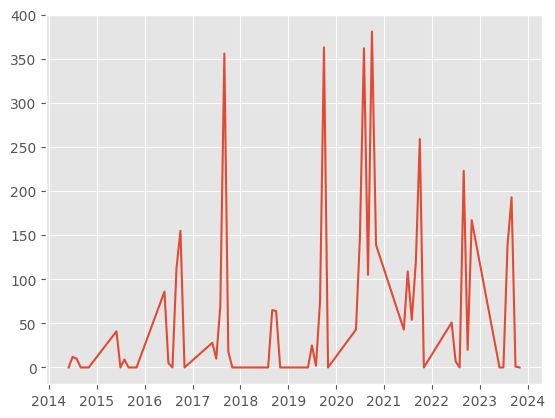

In [67]:
plt.plot(merged_df['month'], merged_df['HD_Store_Count'])